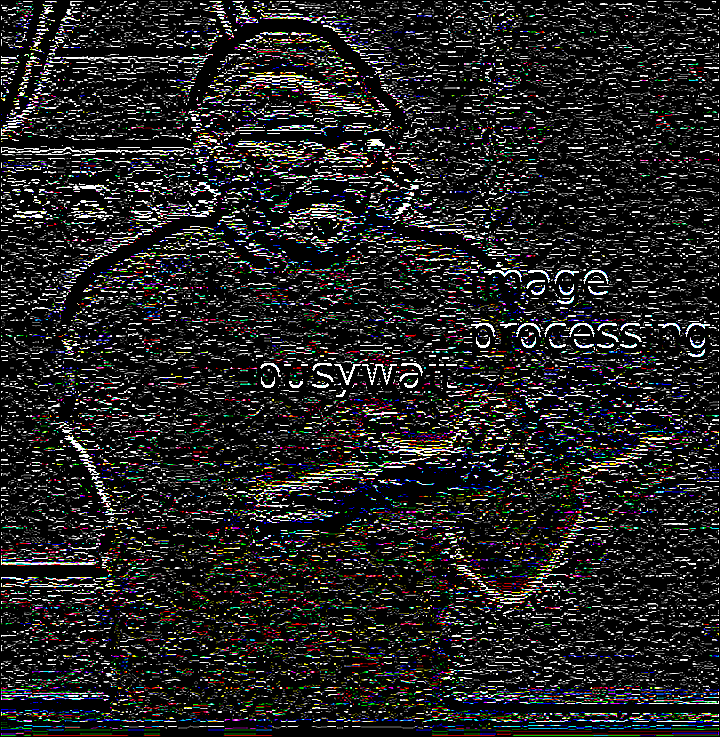

The client requested for the original image to be horizontal edge detected, and sharpened twice. The horizontal edge detection can be made out, but it is harder to detect the sharpening.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def output_to_df(output):
  column_names = [
      "WorkerID",
      "RequestID",
      "ClientRequestTimestamp",
      "ImageOperation",
      "Overwrite",
      "ClientImageID",
      "ServerImageID",
      "ReceiptTimestamp",
      "StartTimestamp",
      "CompletionTimestamp",
  ]

  df = pd.read_csv(output, on_bad_lines='skip', names=column_names)

  return df

def extract_data(df):

  total_busy_time = 0
  for i in range(len(df["RequestID"])):
    request_busy_time = (df["CompletionTimestamp"].iloc[i] - df["StartTimestamp"].iloc[i])
    if request_busy_time > 0:
      total_busy_time += request_busy_time


  total_time = df["CompletionTimestamp"].iloc[-1] - df["ClientRequestTimestamp"].iloc[0]

  utilization = total_busy_time / total_time

  queueingTime = df["StartTimestamp"] - df["ClientRequestTimestamp"]
  serviceTime = df["CompletionTimestamp"] - df["StartTimestamp"]
  df["ResponseTime"] = queueingTime + serviceTime

  avg_response_time = df["ResponseTime"].mean()

  return utilization, avg_response_time

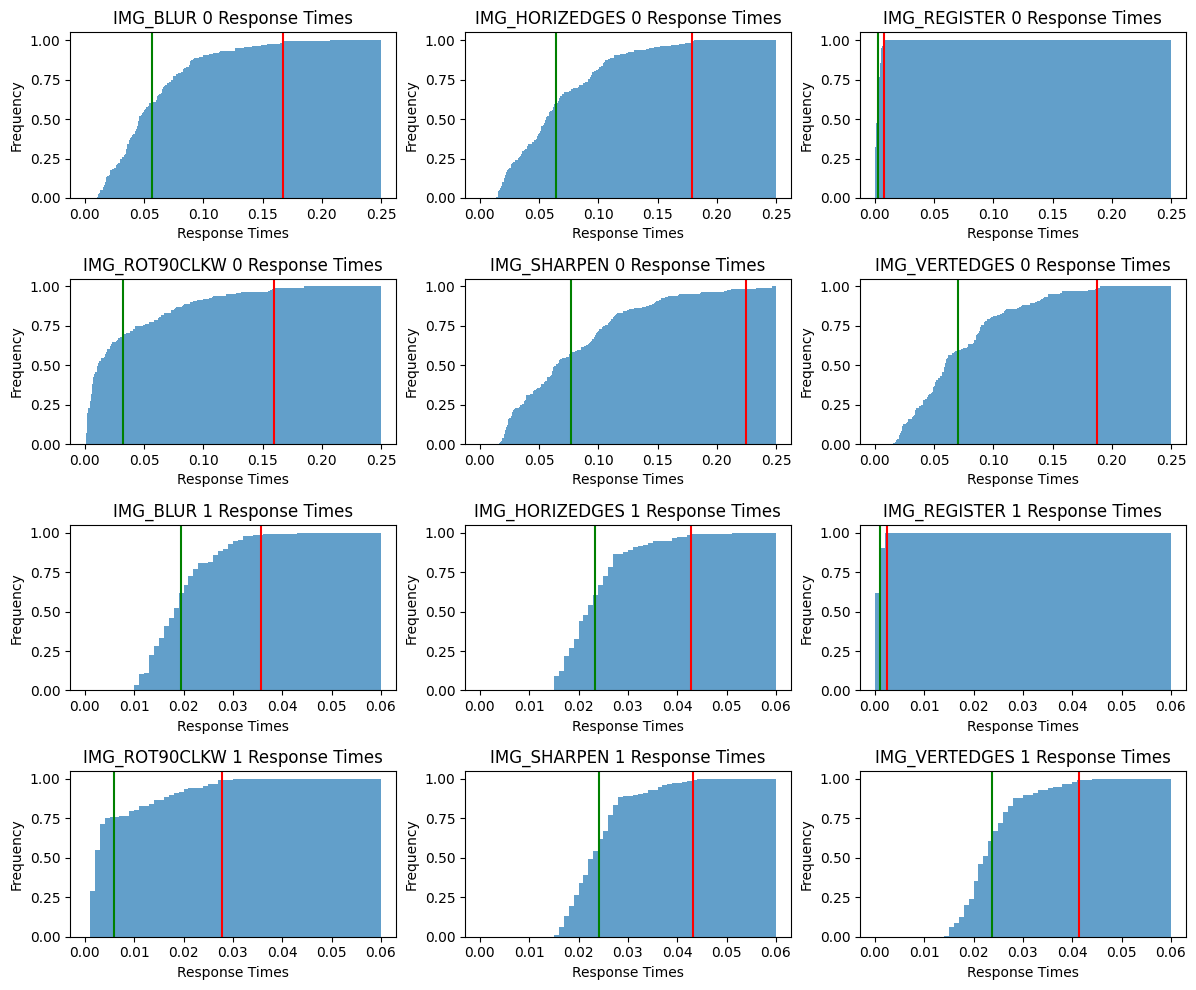

In [ ]:
outputs = ["images-all-output.txt", "images-small-output.txt"]
c = 0
figs, axs = plt.subplots(4, 3, figsize=(12, 10))

for i in range(len(outputs)):
  data = output_to_df(outputs[i])
  dfs = {group: group_df for group, group_df in data.groupby("ImageOperation")}

  for group in dfs:
    if group == "IMG_RETRIEVE":
      continue
    extract_data(dfs[group])
    rts = dfs[group]["ResponseTime"]
    rts = np.sort(rts)
    percentile = np.percentile(rts, 99)
    mean_rt = np.mean(rts)

    # Make plot

    if i == 0:
      bin_width = 0.001
      bins = np.arange(0, 0.25 + bin_width, bin_width)
    else:
      bin_width = 0.001
      bins = np.arange(0, 0.06 + bin_width, bin_width)

    ax = axs.flat[c]
    ax.hist(rts, bins=bins, density=True, cumulative=True, alpha=0.7)
    ax.axvline(x=percentile, color='red')
    ax.axvline(x=mean_rt, color='green')
    ax.set_title(f"{group} {i} Response Times")
    ax.set_xlabel("Response Times")
    ax.set_ylabel("Frequency")

    c += 1



plt.tight_layout()
plt.show()


It seems like most of the normal operations behave similarly in terms of the distribution of response times, but registering takes a very short amount of time. It seems like the least predictable operation, at least for the all images run, is image sharpen, because the 99th percentile is the farthest away from the mean. For both runs, registering an image is by far the shortest and most predictable. For each operation other than register, the response times over doubles when operating on all of the images rather than the two smallest images. The tail increases even more for each operation, increasing by roughly 3x over each operation.

In [ ]:
def estimator(rts):

  if len(rts) == 1:
    return rts[0]
  elif len(rts) == 0:
    print("Error: Must input non-empty list")
    return -1

  return rts[-1] * 0.7 + 0.3 * estimator(rts[:-1])

In [ ]:
data = output_to_df("images-all-output.txt")
extract_data(data)
dfs = {group: group_df for group, group_df in data.groupby("ImageOperation") if group != "IMG_RETRIEVE"}

for group in dfs:
  image_operation = group
  rts = dfs[group]["ResponseTime"].tolist()
  error = 0
  for i in range(len(rts) - 1):
    prediction = estimator(rts[:i+1])
    actual = rts[i+1]
    error += abs(prediction - actual)

  print(f"Average error {image_operation}: ", error / len(rts))

Average error IMG_BLUR:  0.02984285050088417
Average error IMG_HORIZEDGES:  0.03503749147778827
Average error IMG_REGISTER:  0.0018890506692807922
Average error IMG_ROT90CLKW:  0.03534705602621567
Average error IMG_SHARPEN:  0.03891245790336378
Average error IMG_VERTEDGES:  0.03451475279095653


It seems like the predictor works similarly well for all operations, except it works extremely well for register because there is such little variance in the response times for registering images.

0.049315466999541965
0.04938669300172478
0.04956393199181184


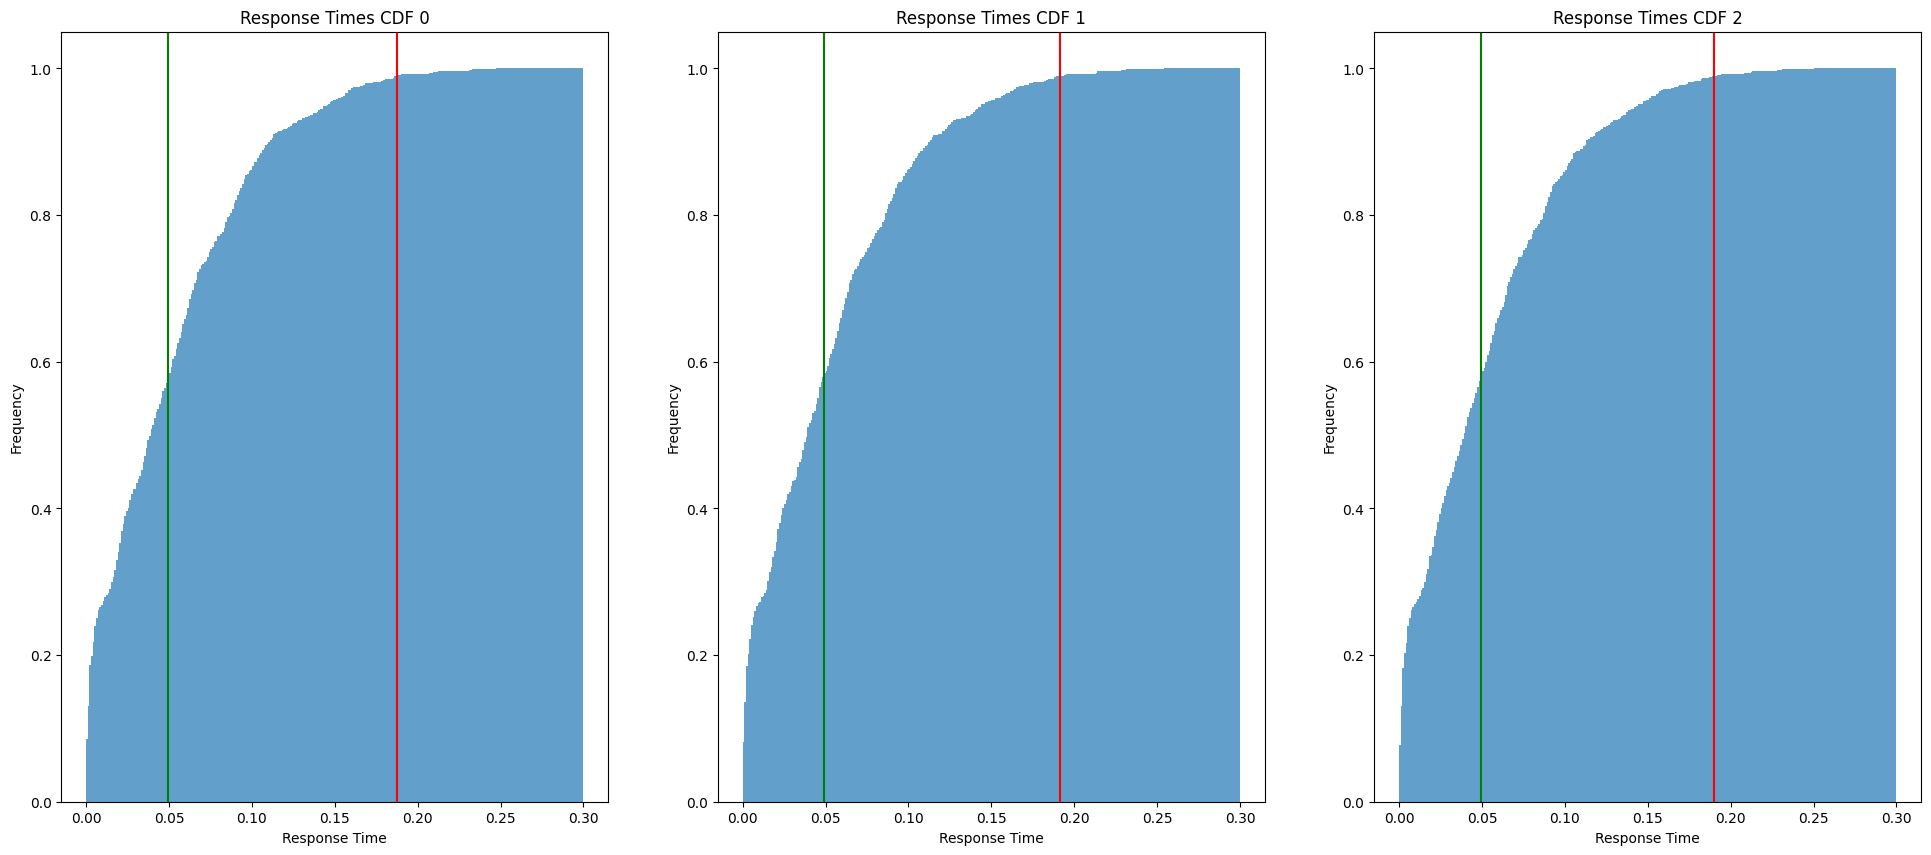

In [ ]:
df0 = output_to_df("images-all-output.txt")
df1 = output_to_df("images-all-output-O1.txt")
df2 = output_to_df("images-all-output-O2.txt")

extract_data(df0)
extract_data(df1)
extract_data(df2)

dfs = [df0, df1, df2]

fig, axs = plt.subplots(1, 3, figsize = (24, 10))
c = 0

for df in dfs:
  rts = df["ResponseTime"]
  rts = np.sort(rts)
  mean = np.mean(rts)
  print(mean)
  percentile = np.percentile(rts, 99)

  ax = axs.flat[c]

  bin_width = 0.001
  bins = np.arange(0, 0.3 + bin_width, bin_width)

  ax.hist(rts, bins=bins, density=True, cumulative=True, alpha=0.7)
  ax.axvline(x=mean, color='green')
  ax.axvline(x=percentile, color='red')
  ax.set_title(f"Response Times CDF {c}")
  ax.set_xlabel("Response Time")
  ax.set_ylabel("Frequency")

  c += 1

plt.show()

The -O flag is meant to set the optimization level of the compiler. The higher the value, the faster you would expect your code to run. However, there is no significant increase in the response times between runs, so it does not seem to be working as expected. In fact, the average response time slightly increases the higher the optimization level, which is surely not what I would expect.